# Car Classification Using CNN and Transfer Learning

### By: Fulgent Kvasir E. Lavesores


## Definition of the Problem

The goal of this project is to build a Convolutional Neural Network (CNN) that classifies car images into their respective makes and models. Using Convolutional Neural Network, I aim to fine-tune its layers to adapt it to a dataset containing car images with bounding boxes and class labels. The project seeks to:
1. Process the car dataset and prepare it for training.
2. Train the CNN model using a combination of transfer learning and custom classification layers.
3. Evaluate the model's performance on unseen test data.


## Data Acquisition

The dataset used in this project is the **Stanford Cars Dataset**, which includes:
- **Training Images**: 8,144 car images, each annotated with bounding boxes and class labels.
- **Testing Images**: 8,041 car images with similar annotations.

The dataset was loaded using the `scipy.io` library from `.mat` files. Bounding boxes were used to crop images before feeding them into the model.

### Source:
Stanford Cars Dataset ([https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset/data](https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset/data))


## Exploration and Analysis of Data

>### Key Points:
>> 1. **Number of Classes**: 196 car classes.
>> 2. **Number of Images**:
>>>   - Training: 8,144 images
>>>   - Testing: 8,041 images
>> 3. **Bounding Boxes**: Each image has a bounding box annotation for cropping the car region.
>> 4. **Dataset Distribution**: Class distribution is balanced, with each class having a similar number of images.
>
>
> ### Descriptive Statistics:
>> Statistical analysis was performed to understand the data distribution. Key insights include:
>>> - The bounding box coordinates vary across the dataset.
>>> - The dataset covers a wide range of car models, providing good diversity.
>
>
> ### Visualizations:
>> Plots were created to visualize:
>>> - Training loss and accuracy over epochs.
>>> - Validation performance trends during training.


## Data Preparation
>
> ### Steps:
>
>> 1. **Loading and Parsing Annotations**:
>>>   - Annotations were loaded from `.mat` files for training and testing datasets.
>>>   - Bounding box coordinates were extracted to crop images.
>>
>> 2. **Data Splitting**:
>>>   - The training dataset was split into:
>>>     - **Training Set**: 8144 data images
>>>     - **Validation Set**: 8041 data images
>>
>> 3. **Preprocessing**:
>>>   - Images were resized to 224x224 pixels.
>>>   - Pixel values were normalized to the range [0, 1].
>>
>> 4. **Data Augmentation**:
>>>   - Techniques such as rotation, zooming, and horizontal flipping were applied to the training data.
>> 5. **Model Preparation**:
>>>   - Custom fully connected layers were added for classification.
>>


### Loading the Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('C:/Users/ASUS/Downloads/CNN_fkvasir/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


### Loading of Dataset

In [4]:
import numpy as np
import pandas as pd
import scipy.io as sio
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load and Prepare Annotations
cars_annos_train = sio.loadmat('C:/Users/ASUS/Downloads/CNN_fkvasir/Standford_cars_dataset/devkit/cars_train_annos.mat')
annotations_train = cars_annos_train['annotations']
annotations_train = np.transpose(annotations_train)

# Parse training annotations
fnames_train = []
bboxes_train = []
for annotation in annotations_train:
    bbox_x1 = annotation[0][0][0][0]
    bbox_y1 = annotation[0][1][0][0]
    bbox_x2 = annotation[0][2][0][0]
    bbox_y2 = annotation[0][3][0][0]
    fname = annotation[0][5][0]
    car_class = annotation[0][4][0]
    bboxes_train.append((fname, bbox_x1, bbox_x2, bbox_y1, bbox_y2, int(car_class[0])))

train_meta = pd.DataFrame(bboxes_train, columns=['fnames', 'bbox_x1', 'bbox_x2', 'bbox_y1', 'bbox_y2', 'car_class'])

# Load test annotations
cars_annos_test = sio.loadmat('C:/Users/ASUS/Downloads/CNN_fkvasir/Standford_cars_dataset/cars_test_annos_withlabels (1).mat')
annotations_test = cars_annos_test['annotations']
annotations_test = np.transpose(annotations_test)

fnames_test = []
bboxes_test = []

for annotation in annotations_test:
    bbox_x1 = annotation[0][0][0][0]
    bbox_y1 = annotation[0][1][0][0]
    bbox_x2 = annotation[0][2][0][0]
    bbox_y2 = annotation[0][3][0][0]
    fname = annotation[0][5][0]
    car_class = annotation[0][4][0]
    bboxes_test.append((fname, bbox_x1, bbox_x2, bbox_y1, bbox_y2, int(car_class[0])))

test_meta = pd.DataFrame(bboxes_test, columns=['fnames', 'bbox_x1', 'bbox_x2', 'bbox_y1', 'bbox_y2', 'car_class'])





### Cleaning the Data (Preprocessing)

In [5]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
train_meta, val_meta = train_test_split(train_meta, test_size=0.2, random_state=42)

# Convert car_class to string (required for categorical mode in ImageDataGenerator)
train_meta['car_class'] = train_meta['car_class'].astype(str)
val_meta['car_class'] = val_meta['car_class'].astype(str)

# Processing and saving training images
for i in range(len(train_meta)):
    img_path = f"C:/Users/ASUS/Downloads/CNN_fkvasir/Standford_cars_dataset/cars_train/cars_train/{train_meta['fnames'].iloc[i]}"
    left, top, right, bottom = train_meta['bbox_x1'].iloc[i], train_meta['bbox_y1'].iloc[i], train_meta['bbox_x2'].iloc[i], train_meta['bbox_y2'].iloc[i]
    if right <= left or bottom <= top:
        print(f"Invalid bbox for image {img_path}: left={left}, top={top}, right={right}, bottom={bottom}")
        continue
    img = Image.open(img_path).crop((left, top, right, bottom))
    img_output = f"C:/Users/ASUS/Downloads/CNN_fkvasir/working/training/{train_meta['fnames'].iloc[i]}"
    img.save(img_output)


# Processing and saving validation images
for i in range(len(val_meta)):
    img_path = f"C:/Users/ASUS/Downloads/CNN_fkvasir/Standford_cars_dataset/cars_train/cars_train/{val_meta['fnames'].iloc[i]}"
    left, top, right, bottom = val_meta['bbox_x1'].iloc[i], val_meta['bbox_y1'].iloc[i], val_meta['bbox_x2'].iloc[i], val_meta['bbox_y2'].iloc[i]
    if right <= left or bottom <= top:
        print(f"Invalid bbox for image {img_path}: left={left}, top={top}, right={right}, bottom={bottom}")
        continue
    img = Image.open(img_path).crop((left, top, right, bottom))
    img_output = f"C:/Users/ASUS/Downloads/CNN_fkvasir/working/validation/{val_meta['fnames'].iloc[i]}"
    img.save(img_output)


# Processing and saving test images
for i in range(len(test_meta)):
    img_path = f"C:/Users/ASUS/Downloads/CNN_fkvasir/Standford_cars_dataset/cars_test/cars_test/{test_meta['fnames'].iloc[i]}"
    left, top, right, bottom = test_meta['bbox_x1'].iloc[i], test_meta['bbox_y1'].iloc[i], test_meta['bbox_x2'].iloc[i], test_meta['bbox_y2'].iloc[i]
    if right <= left or bottom <= top:
        print(f"Invalid bbox for image {img_path}: left={left}, top={top}, right={right}, bottom={bottom}")
        continue
    img = Image.open(img_path).crop((left, top, right, bottom))
    img_output = f"C:/Users/ASUS/Downloads/CNN_fkvasir/working/testing/{test_meta['fnames'].iloc[i]}"
    img.save(img_output)


In [6]:
# Update paths in DataFrame
train_meta['fnames'] = train_meta['fnames'].apply(lambda x: f"training/{x}")
val_meta['fnames'] = val_meta['fnames'].apply(lambda x: f"validation/{x}")
test_meta['fnames'] = test_meta['fnames'].apply(lambda x: f"testing/{x}")

# Convert car_class to string
train_meta['car_class'] = train_meta['car_class'].astype(str)
val_meta['car_class'] = val_meta['car_class'].astype(str)
test_meta['car_class'] = test_meta['car_class'].astype(str)


### Selecting / Transforming / Standardizing Features

In [7]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

training_set = train_datagen.flow_from_dataframe(
    dataframe=train_meta,
    directory="C:/Users/ASUS/Downloads/CNN_fkvasir/working/",
    x_col='fnames',
    y_col='car_class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
# Data augmentation for the validation set
val_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_datagen.flow_from_dataframe(
    dataframe=val_meta,
    directory="C:/Users/ASUS/Downloads/CNN_fkvasir/working/",
    x_col='fnames',
    y_col='car_class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6515 validated image filenames belonging to 196 classes.
Found 1629 validated image filenames belonging to 196 classes.


In [8]:
# Normalize test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_dataframe(
    dataframe=test_meta,
    directory="C:/Users/ASUS/Downloads/CNN_fkvasir/working/",
    x_col='fnames',
    y_col='car_class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



Found 8041 validated image filenames belonging to 196 classes.


### Building CNN Model

In [9]:
# Build the CNN from scratch
model = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Flatten the output
    Flatten(),

    # Fully connected layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer for 196 classes
    Dense(196, activation='softmax')
])


### Training CNN Model

In [10]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(training_set, 
                    validation_data=validation_set, 
                    epochs=30, 
                    callbacks=[early_stopping])


Epoch 1/30
204/204 [==============================] - 649s 3s/step - loss: 5.7180 - accuracy: 0.0068 - val_loss: 5.4276 - val_accuracy: 0.0080
Epoch 2/30
204/204 [==============================] - 513s 3s/step - loss: 5.5969 - accuracy: 0.0075 - val_loss: 5.2866 - val_accuracy: 0.0074
Epoch 3/30
204/204 [==============================] - 514s 3s/step - loss: 5.5327 - accuracy: 0.0072 - val_loss: 5.2068 - val_accuracy: 0.0129
Epoch 4/30
204/204 [==============================] - 532s 3s/step - loss: 5.4980 - accuracy: 0.0068 - val_loss: 5.2046 - val_accuracy: 0.0117
Epoch 5/30
204/204 [==============================] - 545s 3s/step - loss: 5.4744 - accuracy: 0.0060 - val_loss: 5.2034 - val_accuracy: 0.0141
Epoch 6/30
204/204 [==============================] - 526s 3s/step - loss: 5.4187 - accuracy: 0.0095 - val_loss: 5.1837 - val_accuracy: 0.0141
Epoch 7/30
204/204 [==============================] - 1484s 7s/step - loss: 5.4206 - accuracy: 0.0097 - val_loss: 5.1680 - val_accuracy: 0.020

### Visualizations of Training Accuracy and Loss

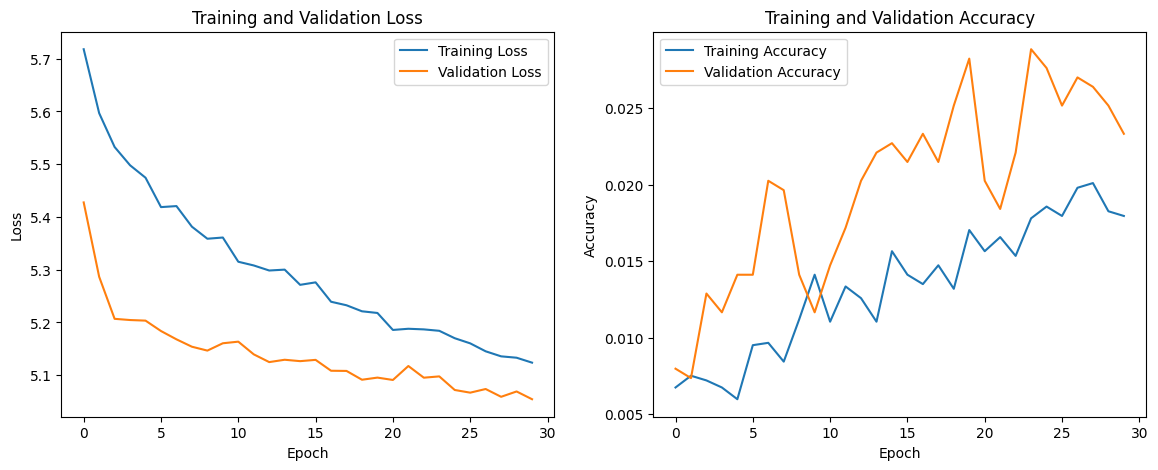

In [11]:
# Visualize training results
plt.figure(figsize=(14, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate and Plot Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_and_plot_confusion_matrix(model, dataset, title, class_names):
    # Get true labels and predictions
    y_true = np.concatenate([y for _, y in dataset], axis=0)
    y_true = np.argmax(y_true, axis=-1)

    y_pred = np.argmax(model.predict(dataset), axis=-1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate per-class accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)

    # Find class with lowest accuracy
    min_acc_class_index = np.argmin(class_accuracies)
    min_acc_class = class_names[min_acc_class_index]
    min_acc_value = class_accuracies[min_acc_class_index]

    print(f"Category with lowest accuracy: {min_acc_class} ({min_acc_value:.2f})")

    # Plot the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", fmt='d')
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Class names for your dataset
class_names = [f"Class {i}" for i in range(196)]  # Replace with actual class names if available

# Generate confusion matrices for validation and test sets
evaluate_and_plot_confusion_matrix(model, validation_set, "Validation", class_names)
evaluate_and_plot_confusion_matrix(model, test_set, "Test", class_names)


### Evaluation of CNN Model

- Testing
- Evaluation Metrics
- Plotting Metrics